In [1]:
import itertools
from basics import *
from plotting import *
from plotting import savefig
from matplotlib import cm
from ase.io import read
import seaborn as sns
from scipy import stats

plt.style.use("paper")

In [2]:
root_dir = "../data/02-mace"
correlations = [1, 2, 3]
fracs = [0, 1, 2, 3, 4]

In [3]:
df = []

for v in correlations:
    for frac in fracs:
        dset_path = os.path.join(root_dir, f"slopes-711-v{v}-{frac}", "711-test.xyz")
        dset = read(dset_path, index=":")

        for i, at in enumerate(dset):
            df.append({
                "index": i,
                "v": v,
                "frac": frac,
                "percent": 0.6 ** frac,
                "crystal_id": at.info["crystal_id"],
                "nads": (at.numbers == 6).sum(),
                "n_atoms": len(at),
                "true": at.info["energy"],
                "pred": at.info["MACE_energy"],
            })

df = pd.DataFrame(df)

In [4]:
df["npred"] = df["pred"] / df["nads"]
df["ntrue"] = df["true"] / df["nads"]

In [5]:
df

,index,v,frac,percent,crystal_id,nads,n_atoms,true,pred,npred,ntrue
0,0,1,0,1.0000,17049,3,78,0.330933,0.382792,0.127597,0.110311
1,1,1,0,1.0000,17100,3,78,0.090593,0.045645,0.015215,0.030198
2,2,1,0,1.0000,17168,3,78,-0.527706,-0.427589,-0.142530,-0.175902
3,3,1,0,1.0000,17219,3,78,3.108176,3.045557,1.015186,1.036059
4,4,1,0,1.0000,17179,3,78,1.637854,1.587822,0.529274,0.545951
...,...,...,...,...,...,...,...,...,...,...,...
3175,207,3,4,0.1296,16737,16,104,62.184370,61.117409,3.819838,3.886523
3176,208,3,4,0.1296,16726,16,104,63.668356,63.314041,3.957128,3.979272
3177,209,3,4,0.1296,16733,16,104,45.138144,44.527325,2.782958,2.821134
3178,210,3,4,0.1296,16785,17,106,60.004095,59.035118,3.472654,3.529653


In [6]:
metrics = []
for (v, frac), grp in df.groupby(["v", "frac"]):    
    _x = grp["ntrue"]
    _y = grp["npred"]
    err = _y - _x
    
    rmse = np.sqrt((err ** 2).mean())
    mae = np.abs(err).mean()
    spearman, _ = stats.spearmanr(_x, _y)
    pearson, _ = stats.pearsonr(_x, _y)
    
    metrics.append({
        "v": v,
        "frac": frac,
        "percent": grp["percent"].iloc[0],
        "rmse": rmse,
        "mae": mae,
        "spearman": spearman,
        "pearson": pearson,
    })

metrics = pd.DataFrame(metrics)

In [7]:
metrics

,v,frac,percent,rmse,mae,spearman,pearson
0,1,0,1.0000,0.025854,0.019665,0.998388,0.999817
1,1,1,0.6000,0.028635,0.022434,0.998620,0.999779
2,1,2,0.3600,0.033894,0.026297,0.997853,0.999687
3,1,3,0.2160,0.035318,0.028203,0.997443,0.999670
4,1,4,0.1296,0.053550,0.038780,0.996054,0.999246
5,2,0,1.0000,0.017776,0.013649,0.999137,0.999914
6,2,1,0.6000,0.020122,0.015009,0.999316,0.999890
7,2,2,0.3600,0.023351,0.017576,0.998875,0.999860
8,2,3,0.2160,0.035632,0.028584,0.997048,0.999667
9,2,4,0.1296,0.050328,0.035023,0.997242,0.999395


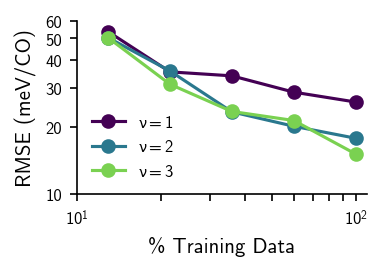

In [8]:
fig, ax = plt.subplots(figsize=(2.5, 1.5))

norm = plt.Normalize(1, 3.5)

for v, grp in metrics.groupby("v"):
    ax.plot(
        grp["percent"] * 100,
        grp["rmse"] * 1e3,
        "o-", label=f"$\\nu = {v}$",
        color=cm.viridis(norm(v))
    )
    
ax.set_xscale("log")
ax.set_yscale("log")

ax.legend(frameon=False)
ax.set_xlim(12, 110)
ax.set_ylim(10, 60)

ax.set_xticks(np.arange(10, 110, 10))

yticks = np.arange(10, 70, 10)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)

ax.set_xlabel("% Training Data")
ax.set_ylabel("RMSE (meV/CO)")

savefig(fig, "03-learning-mace.pdf")
plt.show()